# Galaxies: An interactive graduate course

## Chapter 7: Stars and stellar populations

#### (c) Benedikt Diemer, University of Maryland (based on similar notebooks by Andrey Kravtsov, University of Chicago)

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from routines import common as cmn

# Plotting settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Automatically reload code imported from changed python files
%reload_ext autoreload
%autoreload 2

### 7.1) Star formation

#### 7.1.3) The initial mass function (IMF)

Let's plot different fitting functions for the IMF. Note that the exponents in the following mass functions are larger by unity than those for ${\rm d}n / {\rm d}m$, since we are computing ${\rm d}n / {\rm d} \log_{10} m$.

In [2]:
from colossus.utils import utilities

def imfSalpeter(m):
    
    return m**-1.35

def imfMillerScalo(m):
    
    c0 = 93.2
    c1 = 1.14
    c2 = -0.88
    imf = c0 * np.exp(-c1 * (np.log10(m) - c2)**2)
    
    return imf

def imfChabrier(m):
    
    m, is_array = utilities.getArray(m)
    mask = (m > 1.0)
    A = 0.158
    mc = 0.079
    sig = 0.69
    imf = A * np.exp(-0.5 * (np.log10(m / mc))**2 / sig**2)
    imf[mask] = 4.43E-2 * m[mask]**-1.3
    if not is_array:
        imf = imf[0]
        
    return imf

def imfKroupa(m):
    
    m, is_array = utilities.getArray(m)
    imf = np.zeros_like(m)
    mask1 = (m < 0.5)
    imf[mask1] = 2.0 * m[mask1]**-0.3
    mask2 = (m >= 1.0)
    imf[mask2] = m[mask2]**-1.7
    mask3 = np.logical_not(mask1) & np.logical_not(mask2)
    imf[mask3] = m[mask3]**-1.3
    if not is_array:
        imf = imf[0]
        
    return imf

def integrand(logm, imf_func):
    
    m = 10**logm
    imf = imf_func(m) * m
    
    return imf

imf_funcs = [imfSalpeter, imfMillerScalo, imfKroupa, imfChabrier]
imf_labels = [r'$\mathrm{Salpeter}\ 1955$', r'$\mathrm{Miller\ \&\ Scalo\ 1979}$', 
             r'$\mathrm{Kroupa\ 2002}$', r'$\mathrm{Chabrier\ 2003}$']

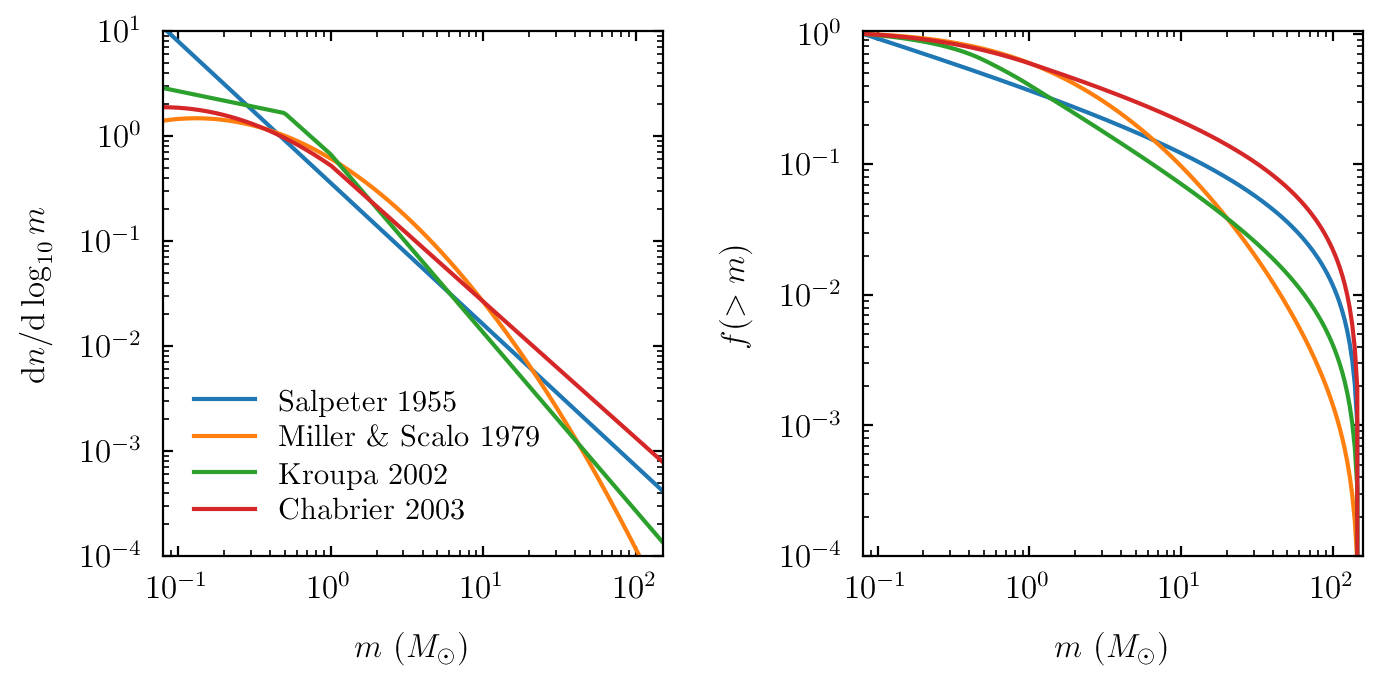

In [3]:
import scipy
from matplotlib.ticker import LogLocator

mmin = 0.08
mmax = 150.0
log_mmin = np.log10(mmin)
log_mmax = np.log10(mmax)
m_plot = 10**np.linspace(log_mmin, log_mmax, 200)

# Compute IMFs and integrate, normalize
imfs = []
imfs_int = []
for i in range(len(imf_funcs)):
    imf = imf_funcs[i](m_plot)
    imf_int = np.zeros_like(m_plot)
    for j in range(len(m_plot)):
        imf_int[j], _ = scipy.integrate.quad(integrand, np.log10(m_plot[j]), log_mmax, args = (imf_funcs[i], ))
    imf /= imf_int[0]
    imf_int /= imf_int[0]
    imfs.append(imf)
    imfs_int.append(imf_int)

# Plot
fig, ax = plt.subplots(1, 2, figsize = (8, 3.5))
plt.subplots_adjust(wspace = 0.4)

plt.sca(ax[0])
plt.xlabel('$m\ (M_{\odot})$')
plt.ylabel(r'${\rm d} n / {\rm d} \log_{10} m$')
plt.loglog()
plt.xlim(mmin, mmax)
plt.ylim(0.0001, 10.0)
ax[0].xaxis.set_major_locator(LogLocator(numticks = 100))
ax[0].xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

for i in range(len(imf_funcs)):
    plt.plot(m_plot, imfs[i], label = imf_labels[i])

plt.legend(loc = 3, labelspacing = 0.3)

plt.sca(ax[1])
plt.xlabel('$m\ (M_{\odot})$')
plt.ylabel(r'$f(>m)$')
plt.loglog()
plt.xlim(mmin, mmax * 1.05)
plt.ylim(0.0001, 1.05)
ax[1].xaxis.set_major_locator(LogLocator(numticks = 100))
ax[1].xaxis.set_minor_locator(LogLocator(numticks = 100, subs = np.arange(2, 10)))

for i in range(len(imf_funcs)):
    plt.plot(m_plot, imfs_int[i], label = imf_labels[i])

plt.show()

### 7.3) Galactic spectra from stellar population synthesis

For this section, we use the [EzGal](http://www.baryons.org/ezgal/) code, a simple interface for SPS calculations. You can learn more about the code from its [manual](http://www.baryons.org/ezgal/manual/) (also available as [pdf])(http://www.baryons.org/ezgal/manual.pdf)) and the code paper ([Mancone & Gonzalez 2012](http://adsabs.harvard.edu/abs/2012PASP..124..606M)). In principle, the code can be installed with ``pip install ezgal``, but this option did not work on my laptop. Instead, you can clone the [repository](https://github.com/cmancone/easyGalaxy) and add its path to your ``PYTHONPATH`` environment variable.

#### 7.3.1) Simple stellar populations

Let's create a simple stellar population (SSP) with a fiducial model, namely the [Conroy et al. 2009](http://adsabs.harvard.edu/abs/2009ApJ...699..486C) stellar library, a metallicity of $Z = Z_\odot = 0.019$, and a [Chabrier 2003](https://ui.adsabs.harvard.edu/abs/2003PASP..115..763C/abstract) IMF. We also create model variations to check the impact of each of these choices. EzGal also lets us create a redshift array from a formation redshift $z_{\rm f}$. Let's plot how the spectrum of this SSP evolves with time.

In [4]:
import ezgal

def getSSP(speclib = 'c09', Z = 0.019, imf = 'chab'):
    
    if speclib == 'c09':
        fn_model = cmn.data_dir + 'ezgal/models/%s_ssp_z_%s_%s.model' % (speclib, str(Z), imf)
    elif speclib == 'bc03':
        fn_model = cmn.data_dir + 'ezgal/models/%s_burst_0.1_z_%s_%s.model' % (speclib, str(Z), imf)
    else:
        raise Exception('Not sure how to construct filename for speclib %s.' % (speclib))
        
    ssp = ezgal.model(fn_model)
    
    return ssp

# Metallicities available for Conroy+09 model
all_Z_c09 = [0.002, 0.0025, 0.0049, 0.0096, 0.019, 0.024, 0.03]
models_Z = []
for i in range(len(all_Z_c09)):
    models_Z.append(getSSP(Z = all_Z_c09[i]))

# Create SSP models
ssp = getSSP()
ssp_bc03 = getSSP(speclib = 'bc03', Z = 0.02)
ssp_lowz = getSSP(Z = 0.002)
ssp_salp = getSSP(imf = 'salp')

models = [ssp, ssp_bc03, ssp_lowz, ssp_salp]
model_labels = [r'$\mathrm{Fiducial}$', r'$\mathrm{BC03\ library}$', r'$Z = 0.1\ Z_\odot$', 
                r'$\mathrm{Salpeter\ IMF}$']

# Create an array of redshifts and times where we will evaluate the models. We 
# assume a formation redshift of 5, but this doesn't matter much in detail.
zf = 5.0
zs = ssp.get_zs(zf)
t = ssp.get_age(zf, zs)

/Users/benedito/University/data/teaching/data_astro_620/data_files/ezgal/models/c09_ssp_z_0.002_chab.model
/Users/benedito/University/data/teaching/data_astro_620/data_files/ezgal/models/c09_ssp_z_0.0025_chab.model
/Users/benedito/University/data/teaching/data_astro_620/data_files/ezgal/models/c09_ssp_z_0.0049_chab.model
/Users/benedito/University/data/teaching/data_astro_620/data_files/ezgal/models/c09_ssp_z_0.0096_chab.model
/Users/benedito/University/data/teaching/data_astro_620/data_files/ezgal/models/c09_ssp_z_0.019_chab.model
/Users/benedito/University/data/teaching/data_astro_620/data_files/ezgal/models/c09_ssp_z_0.024_chab.model
/Users/benedito/University/data/teaching/data_astro_620/data_files/ezgal/models/c09_ssp_z_0.03_chab.model
/Users/benedito/University/data/teaching/data_astro_620/data_files/ezgal/models/c09_ssp_z_0.019_chab.model
/Users/benedito/University/data/teaching/data_astro_620/data_files/ezgal/models/bc03_burst_0.1_z_0.02_chab.model
/Users/benedito/University/da

Let's have a look at the predicted evolution of the spectrum of the SSP.

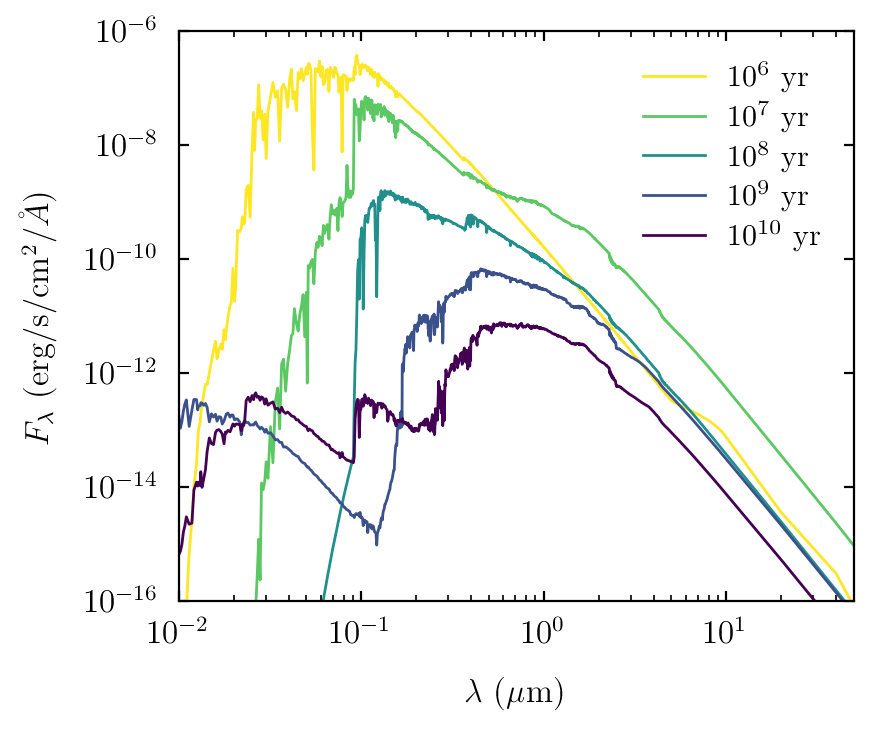

In [5]:
log_t_plot = [6, 7, 8, 9, 10]
cmap = plt.get_cmap('viridis_r')

plt.figure(figsize = (4.5, 3.8))
plt.loglog()
plt.xlabel(r'$\lambda\ (\mu {\rm m})$')
plt.ylabel(r'$F_\lambda\ ({\rm erg} / {\rm s} / {\rm cm}^2 / \AA)$')
plt.xlim(1E-2, 5E1)
plt.ylim(1E-16, 1E-6)

for i, log_t in enumerate(log_t_plot):
    sed = ssp.get_sed(10**log_t, age_units = 'yrs', units = 'Fl')
    c = cmap(float(i) / (len(log_t_plot) - 1.0))
    plt.plot(ssp.ls / 1E4, sed, c = c, lw = 1.0, label = r'$10^{%d}\ {\rm yr}$' % log_t)

plt.legend(labelspacing = 0.3)
plt.show()

Let's see how much these spectra vary depending on our choices.

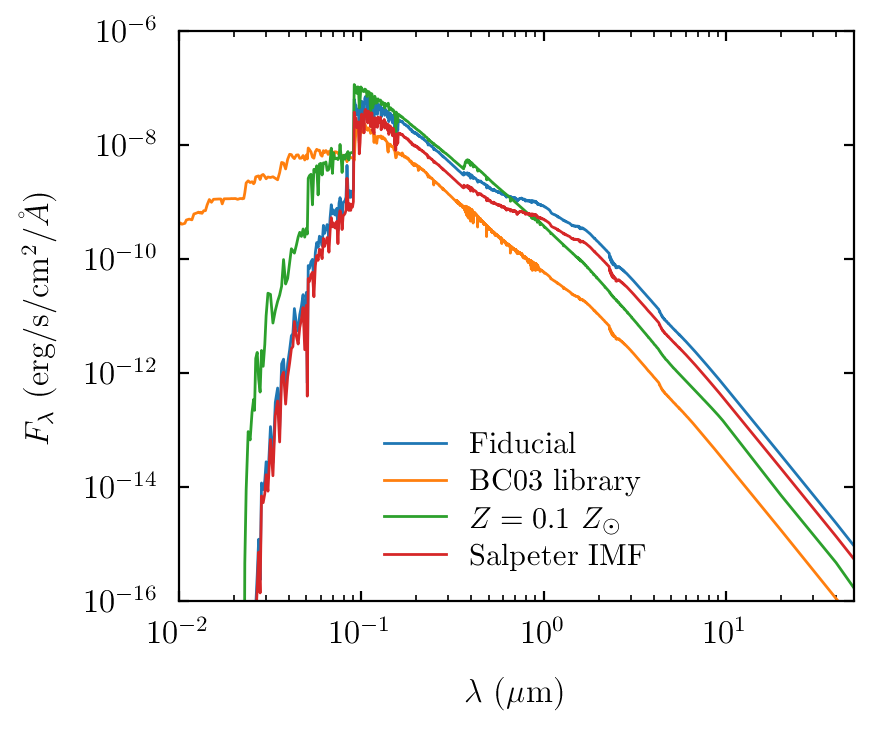

In [6]:
t_plot = 1E7

plt.figure(figsize = (4.5, 3.8))
plt.loglog()
plt.xlabel(r'$\lambda\ (\mu {\rm m})$')
plt.ylabel(r'$F_\lambda\ ({\rm erg} / {\rm s} / {\rm cm}^2 / \AA)$')
plt.xlim(1E-2, 5E1)
plt.ylim(1E-16, 1E-6)

for i, m in enumerate(models):
    sed = m.get_sed(t_plot, age_units = 'yrs', units = 'Fl')
    plt.plot(m.ls / 1E4, sed, lw = 1.0, label = model_labels[i])

plt.legend(labelspacing = 0.3)
plt.show()

We can now investigate summary quantities such as magnitudes.

/Users/benedito/University/code/_external/easyGalaxy/ezgal/cosmology.py:185: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)


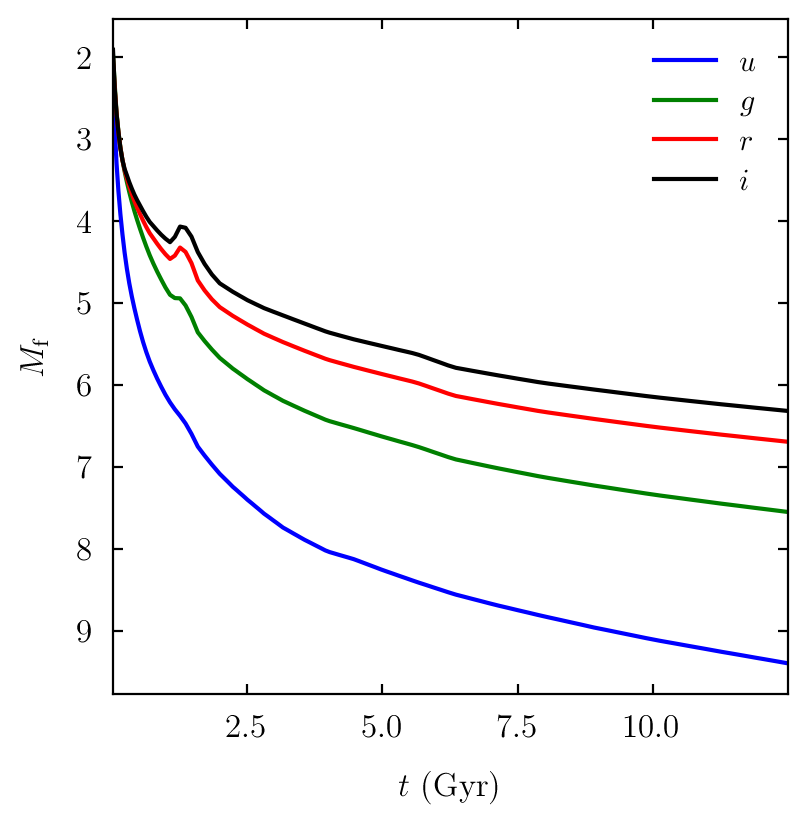

In [7]:
Mu_ssp = ssp.get_absolute_mags(zf, filters = 'sloan_u', zs = zs)
Mg_ssp = ssp.get_absolute_mags(zf, filters = 'sloan_g', zs = zs)
Mr_ssp = ssp.get_absolute_mags(zf, filters = 'sloan_r', zs = zs)
Mi_ssp = ssp.get_absolute_mags(zf, filters = 'sloan_i', zs = zs)

plt.figure()
plt.xlabel(r'$t\ ({\rm Gyr})$')
plt.ylabel(r'$M_{\rm f}$')
plt.xlim(t[-1], t[0])
plt.gca().invert_yaxis()

plt.plot(t, Mu_ssp, color = 'b', label = r'$u$')
plt.plot(t, Mg_ssp, color = 'g', label = r'$g$')
plt.plot(t, Mr_ssp, color = 'r', label = r'$r$')
plt.plot(t, Mi_ssp, color = 'k', label = r'$i$')

plt.legend()
plt.show()

As expected, the flux decreases in all filters, but particularly strongly in the UV. These differences are easier to see when plotting the evolution of colors.

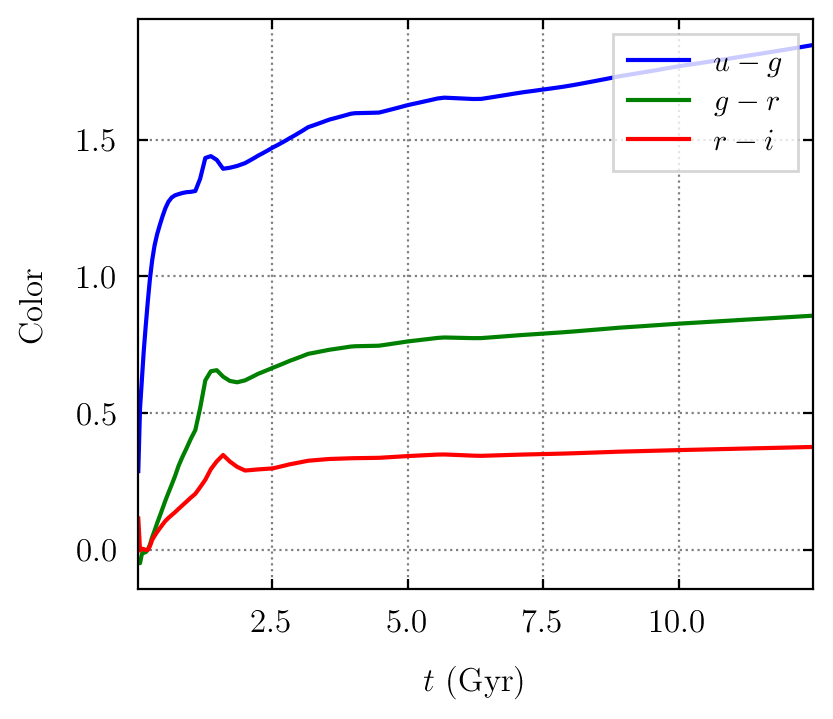

In [8]:
ug_ssp = Mu_ssp - Mg_ssp
gr_ssp = Mg_ssp - Mr_ssp
ri_ssp = Mr_ssp - Mi_ssp

plt.figure(figsize = (4.5, 3.8))
plt.xlabel(r'$t\ ({\rm Gyr})$')
plt.ylabel(r'${\rm Color}$')
plt.grid(ls = ':', color = 'gray')
plt.xlim(t[-1], t[0])

plt.plot(t, ug_ssp, color = 'b', label = r'$u-g$')
plt.plot(t, gr_ssp, color = 'g', label = r'$g-r$')
plt.plot(t, ri_ssp, color = 'r', label = r'$r-i$')

plt.legend(frameon = True)
plt.show()

The $g-r$ color increases significantly with stellar age, from $\sim 0$ to $\sim 0.8$. Let's again check how much this result depends on the modeling choices.

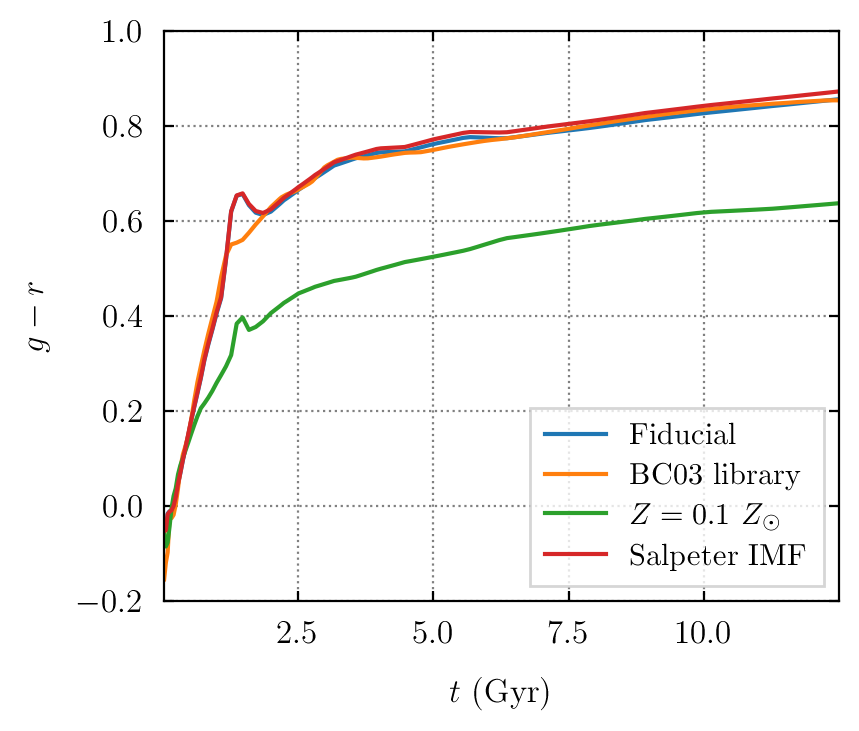

In [9]:
plt.figure(figsize = (4.5, 3.8))
plt.xlabel(r'$t\ ({\rm Gyr})$')
plt.ylabel(r'$g-r$')
plt.grid(ls = ':', color = 'gray')
plt.xlim(t[-1], t[0])
plt.ylim(-0.2, 1.0)

for i, m in enumerate(models):
    Mg = m.get_absolute_mags(zf, filters = 'sloan_g', zs = zs)
    Mr = m.get_absolute_mags(zf, filters = 'sloan_r', zs = zs)
    gr = Mg - Mr
    plt.plot(t, gr, label = model_labels[i])

plt.legend(frameon = True)
plt.show()

While the color evolution depends quite strongly on metallicity, it is fairly insensitive to the modeling choices. That's good! However, the dependences on metallicity and age are hard to discern. Let's plot the dependence on metallicity in more detail.

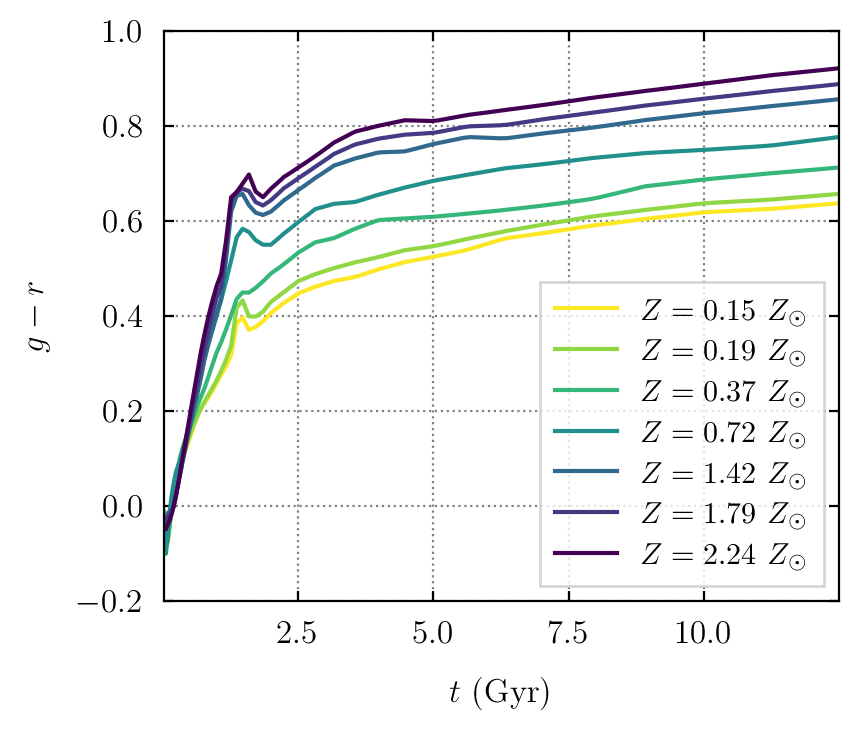

In [10]:
plt.figure(figsize = (4.5, 3.8))
plt.xlabel(r'$t\ ({\rm Gyr})$')
plt.ylabel(r'$g-r$')
plt.grid(ls = ':', color = 'gray')
plt.xlim(t[-1], t[0])
plt.ylim(-0.2, 1.0)

for i in range(len(all_Z_c09)):
    Z = all_Z_c09[i]
    m = models_Z[i]
    Mg = m.get_absolute_mags(zf, filters = 'sloan_g', zs = zs)
    Mr = m.get_absolute_mags(zf, filters = 'sloan_r', zs = zs)
    gr = Mg - Mr
    c = cmap(float(i) / (len(all_Z_c09) - 1.0))
    plt.plot(t, gr, c = c, label = r'$Z = %.2f\ Z_\odot$' % (Z / cmn.Z_SOLAR))

plt.legend(frameon = True)
plt.show()

If we see a population with red color, we do not know whether we are looking at high metallicity or old age. This is known as the "age-metallicity degeneracy."

#### 7.3.2) Composite stellar populations

Since we do not generally know the exact star formation history (SFH) of a galaxy, we need to add some theoretical predscription for when stars formed. A number of formulae are commonly used in the literature.

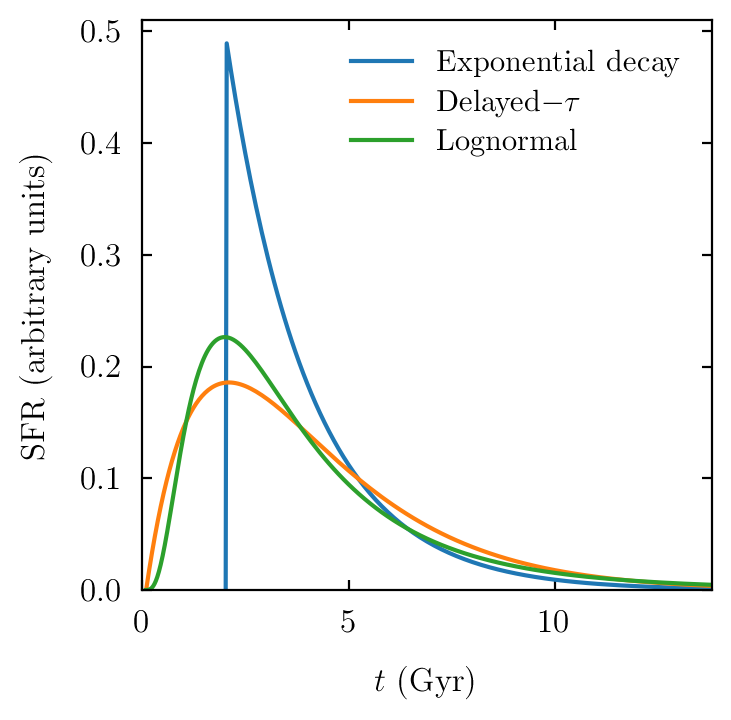

In [11]:
def sfrExponential(t, ti, tf, tau):
    
    A_tau = 1.0 / (1.0 - np.exp(-(tf - ti) / tau)) / tau
    psi = A_tau * np.exp(-(t - ti) / tau) * (t - ti) / np.abs(t - ti)
    
    return psi

def sfrDelayedTau(t, ti, tf, tau):
    
    A_tau = 1.0 / (-np.exp(-(tf - ti) / tau) - np.exp(-(tf - ti) / tau) * (tf - ti) / tau \
                   - np.exp(ti / tau) * (ti / tau - 1.0))
    psi = A_tau * np.exp(-(t - ti) / tau) * (t - ti) / tau**2
    
    return psi

def sfrLognormal(t, t0, tau):
    
    A_tau = 1.0 / np.log(tau) / np.sqrt(2.0 * np.pi) / t
    psi = A_tau * np.exp(-0.5 * (np.log(t) - np.log(t0) - np.log(tau)**2)**2 / (np.log(tau)**2))
    
    return psi

tf = cmn.cosmo.age(0.0)
log_tplot = np.linspace(-1.0, np.log10(tf), 200)
t_plot = 10**log_tplot

psi_exp = sfrExponential(t_plot, 2.0, tf, 2.0)
psi_del = sfrDelayedTau(t_plot, 0.1, tf, 2.0)
psi_ln = sfrLognormal(t_plot, 2.0, 2.0)

plt.figure(figsize = (3.8, 3.8))
plt.xlabel(r'$t\ ({\rm Gyr})$')
plt.ylabel(r'${\rm SFR}\ (\mathrm{arbitrary\ units})$')
plt.xlim(0.0, tf)
plt.ylim(0.0, 0.51)

plt.plot(t_plot, psi_exp, label = r'$\mathrm{Exponential\ decay}$')
plt.plot(t_plot, psi_del, label = r'$\mathrm{Delayed-}\tau$')
plt.plot(t_plot, psi_ln, label = r'$\mathrm{Lognormal}$')

plt.legend()
plt.show()

We can now use the SFH forms to create some composite stellar populations (CSPs). Let's plot the CSP spectral evolution. We compare three different models: exponential decay with $\tau = 0.2$ and $2\ {\rm Gyr}$, and delayed-$\tau$ with $\tau = 1\ {\rm Gyr}$. The log-normal looks similar enough to the latter that it won't make much difference here. One important aspect we are not integrating into our CSPs is dust, but doing so demands adding a non-trivial function of age and wavelength.

In [12]:
def sfrSimpleExponential(t, tau):
    
    return np.exp(-t / tau)    

def sfrSimpleDelayedTau(t, tau):
    
    return np.exp(-t / tau) * t / tau    

csp_exp_tau1 = ssp.make_csp(sfrSimpleExponential, args = (0.2,))
csp_exp_tau2 = ssp.make_csp(sfrSimpleExponential, args = (2.0,))
csp_del_tau2 = ssp.make_csp(sfrSimpleDelayedTau, args = (1.0,))
csp_del_tau2_salp = ssp_salp.make_csp(sfrSimpleDelayedTau, args = (1.0,))

# Model set with different SFHs
models_csp = [csp_exp_tau1, csp_exp_tau2, csp_del_tau2]
labels_csp = [r'$\mathrm{Exponential,}\ \tau = 0.2\ {\rm Gyr}$', r'$\mathrm{Exponential,}\ \tau = 2\ {\rm Gyr}$',
             r'$\mathrm{Delayed-}\tau,\ \tau = 1\ {\rm Gyr}$']
ls_csp = ['-', '--', '-.']

# Extended model set with different IMF as well
models_csp_plus = models_csp + [csp_del_tau2_salp]
labels_csp_plus = labels_csp + [r'$\mathrm{Delayed-}\tau,\ \mathrm{Salpeter\ IMF}$']

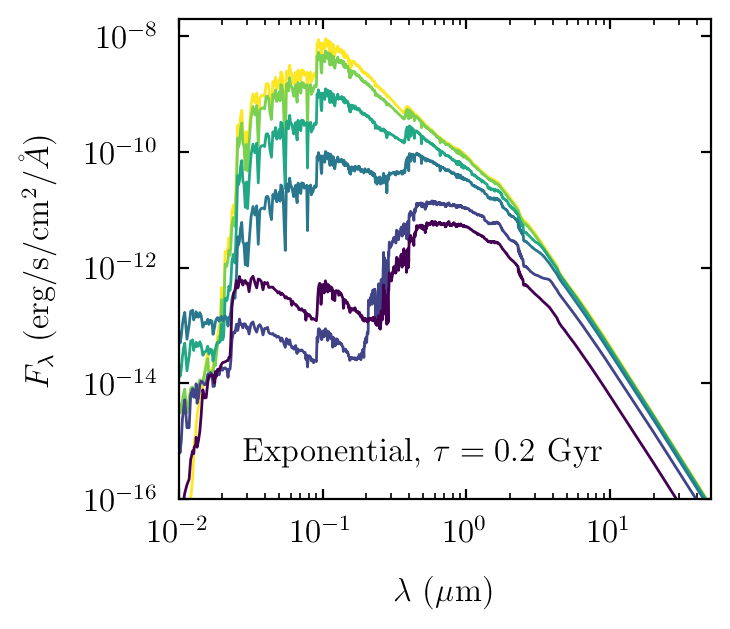

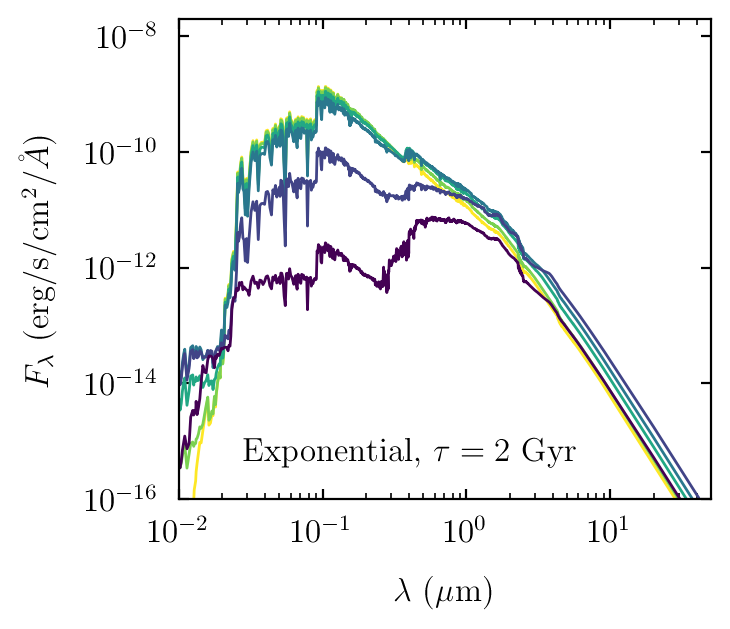

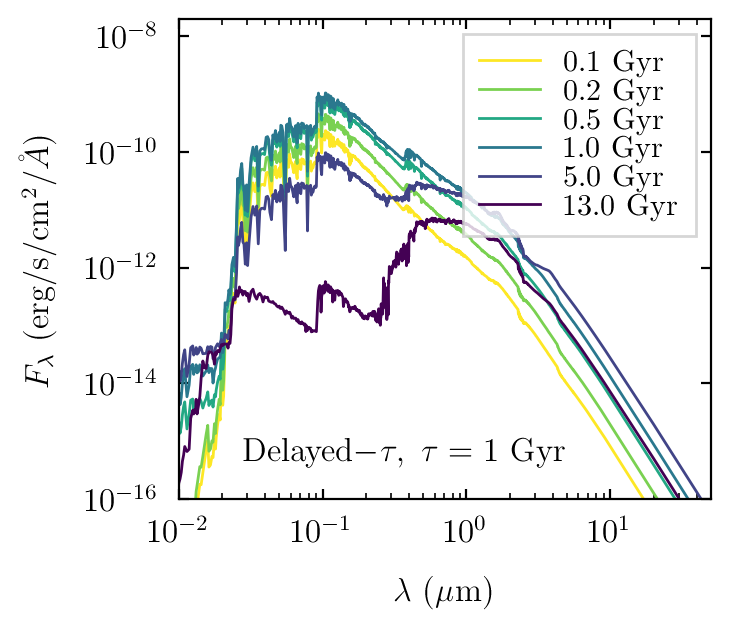

In [13]:
t_plot = np.array([0.1, 0.2, 0.5, 1.0, 5.0, 13.0]) * 1E9
cmap = plt.get_cmap('viridis_r')

for j in range(len(models_csp)):
    m = models_csp[j]

    plt.figure(figsize = (3.8, 3.2))
    plt.subplots_adjust(left = 0.25)
    plt.loglog()
    plt.xlabel(r'$\lambda\ (\mu {\rm m})$')
    plt.ylabel(r'$F_\lambda\ ({\rm erg} / {\rm s} / {\rm cm}^2 / \AA)$')
    plt.xlim(1E-2, 5E1)
    plt.ylim(1E-16, 2E-8)

    for i, log_t in enumerate(t_plot):
        sed = m.get_sed(t_plot[i], age_units = 'yrs', units = 'Fl')
        c = cmap(float(i) / (len(t_plot) - 1.0))
        plt.plot(m.ls / 1E4, sed, c = c, lw = 1.0, label = r'$%.1f\ {\rm Gyr}$' % (t_plot[i] / 1E9))

    plt.text(0.12, 0.08, labels_csp[j], transform = plt.gca().transAxes, fontsize = 12)
    if j == 2:
        plt.legend(loc = 1, labelspacing = 0.05, frameon = True)
    plt.show()

Let's see how the spectra manifest in the evolution of magnitudes. To keep the plot from getting too messy, we plot only the $u$ and $r$ filters.

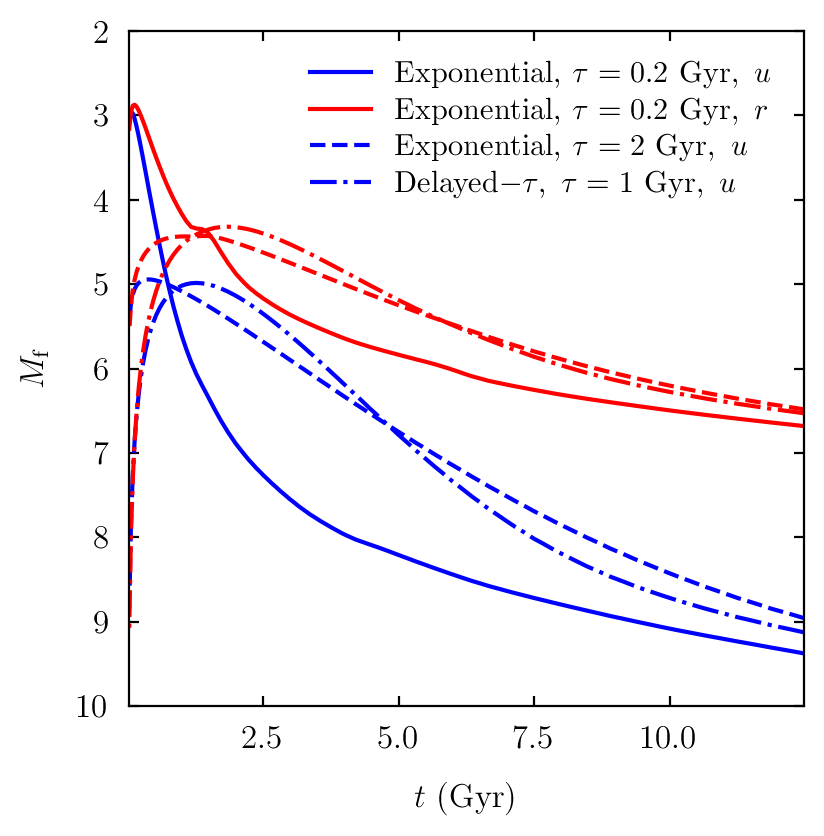

In [14]:
plt.figure()
plt.xlabel(r'$t\ ({\rm Gyr})$')
plt.ylabel(r'$M_{\rm f}$')
plt.xlim(t[-1], t[0])
plt.ylim(2.0, 10.0)
plt.gca().invert_yaxis()

for j in range(len(models_csp)):
    m = models_csp[j]

    Mu_csp = m.get_absolute_mags(zf, filters = 'sloan_u', zs = zs)
    Mr_csp = m.get_absolute_mags(zf, filters = 'sloan_r', zs = zs)

    label = labels_csp[j] + r'$,\ u$'
    plt.plot(t, Mu_csp, color = 'b', ls = ls_csp[j], label = label)
    if j == 0:
        label = labels_csp[j] + r'$,\ r$'
    else:
        label = None
    plt.plot(t, Mr_csp, color = 'r', ls = ls_csp[j], label = label)

plt.legend(labelspacing = 0.3)
plt.show()

Again, the blue wavelengths decline faster than red. We see the SFH reflected in the magnitude evolution, where the exponential with a short $\tau$ declines very rapidly whereas the delayed-$\tau$ model rises first and then gradually declines. Let's see how these trends manifest in the color evolution.

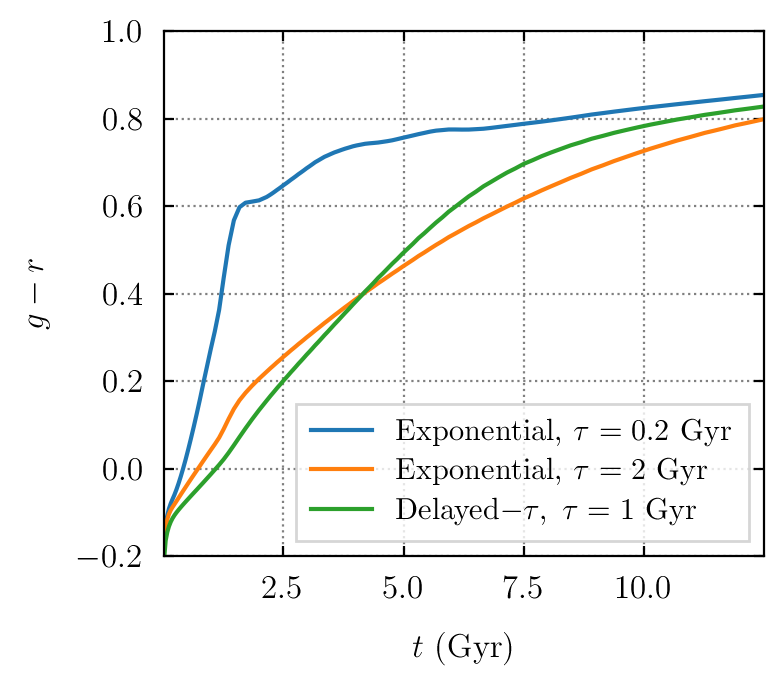

In [15]:
plt.figure(figsize = (4.0, 3.5))
plt.xlabel(r'$t\ ({\rm Gyr})$')
plt.ylabel(r'$g-r$')
plt.grid(ls = ':', color = 'gray')
plt.xlim(t[-1], t[0])
plt.ylim(-0.2, 1.0)

for j in range(len(models_csp)):
    m = models_csp_plus[j]
    Mg = m.get_absolute_mags(zf, filters = 'sloan_g', zs = zs)
    Mr = m.get_absolute_mags(zf, filters = 'sloan_r', zs = zs)
    gr = Mg - Mr
    plt.plot(t, gr, label = labels_csp[j])

plt.legend(frameon = True)
plt.show()

As expected, the color rises rapidly for the short-$\tau$ exponential and more gradually for the slower-declining SFHs. The color evolution of the latter models is quite similar because of the similar SFH shapes at late times. 

#### Passive evolution

So far, we have plotted all evolutions as a function of time, but we have previously invoked the so-called passive evolution of stellar populations when correcting magnitudes for redshift. Let's see what the evolution of the $r$-band magnitude looks like when plotted against redshift.

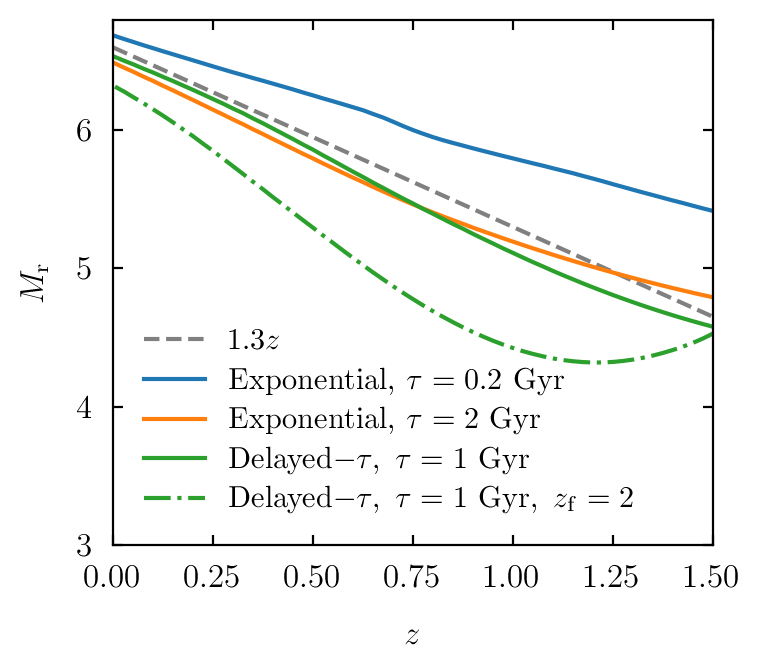

In [16]:
plt.figure(figsize = (4.0, 3.5))
plt.xlabel(r'$z$')
plt.ylabel(r'$M_{\rm r}$')
plt.xlim(0.0, 1.5)
plt.ylim(3.0, 6.8)

z_corr = np.array([0.0, 1.5])
Mr_corr = 6.6 - 1.3 * z_corr
plt.plot(z_corr, Mr_corr, ls = '--', color = 'gray', label = r'$1.3z$')

for j in range(len(models_csp)):
    m = models_csp[j]
    Mr = m.get_absolute_mags(zf, filters = 'sloan_r', zs = zs)
    plt.plot(zs, Mr, label = labels_csp[j])

    if j == len(models_csp) - 1:
        Mr = m.get_absolute_mags(2.0, filters = 'sloan_r', zs = zs)
        plt.plot(zs, Mr, label = labels_csp[j] + r'$,\ z_{\rm f} = 2$', color = cmn.color_cycle[j], ls = '-.')
    
plt.legend(frameon = False, loc = 3)
plt.show()

The gray line shows the correction factor of $1.3 z$ that we used when considering Malmquist bias. It describes the evolution of relatively old stellar populations (since ours started at $z = 5$).

### 7.4) Observable indicators of stellar mass and SFR

#### 7.4.1) Measuring stellar mass via the mass-to-light radio

One really important prediction we can now make based on SPS is the mass-to-light ratio, which lets us estimate stellar masses from magnitudes.

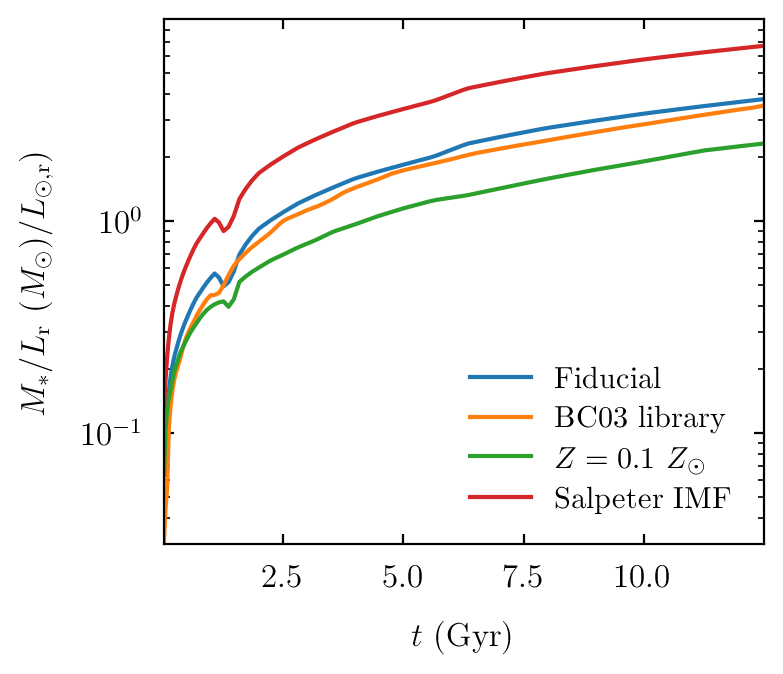

In [17]:
plt.figure(figsize = (4.0, 3.5))
plt.xlabel(r'$t\ ({\rm Gyr})$')
plt.ylabel(r'$M_{\ast} / L_{\rm r} \ (M_\odot) / L_{\rm \odot, r})$')
plt.yscale('log')
plt.xlim(t[-1], t[0])
plt.ylim(3E-2, 9E0)

for i, m in enumerate(models):
    ml_r = m.get_rest_ml_ratios(zf, filters = 'sloan_r', zs = zs)
    plt.plot(t, ml_r, label = model_labels[i])

plt.legend(loc = 4)
plt.show()

Over time, the $M_\ast / L$ of a population increases, or rather, $L$ drops while $M_\ast$ stays more or less constant. This makes sense, since $L \propto M_\ast^{3.9}$, meaning that large, short-lived stars emit disproportional amounts of light.

The spectral library does not make a huge difference for the predictions, but the IMF does! As we saw above, the Salpeter IMF predicts a higher fraction of stars at low masses and fewer at high masses compared to our fiducial Chabrier IMF. Given that high-mass stars shine much more brightly per unit mass, this means a higher mass-to-light ratio. The IMF is thus one of the main uncertainties in our estimates of stellar masses.

Let's make the same plot but show the predictions for our CSPs.

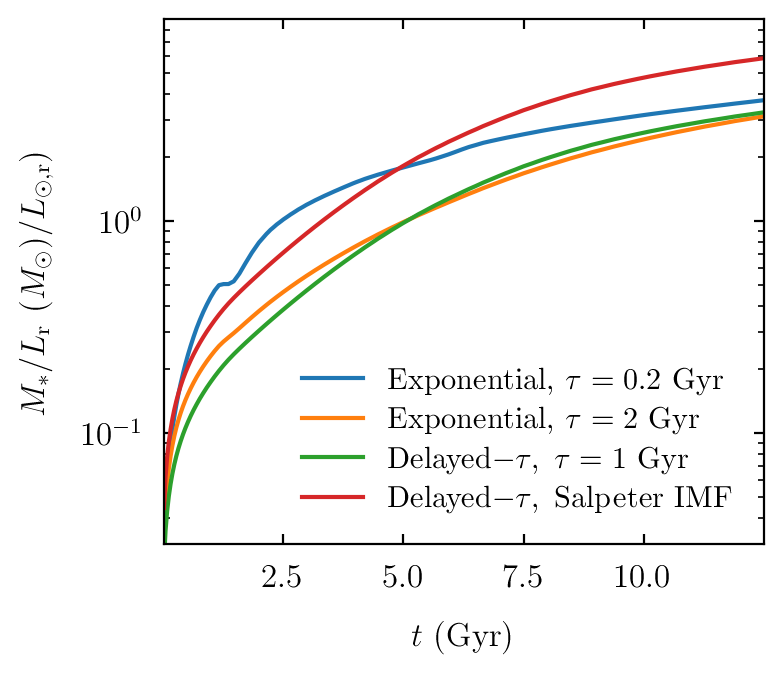

In [18]:
plt.figure(figsize = (4.0, 3.5))
plt.xlabel(r'$t\ ({\rm Gyr})$')
plt.ylabel(r'$M_{\ast} / L_{\rm r} \ (M_\odot) / L_{\rm \odot, r})$')
plt.yscale('log')
plt.xlim(t[-1], t[0])
plt.ylim(3E-2, 9E0)

for i, m in enumerate(models_csp_plus):
    ml_r = m.get_rest_ml_ratios(zf, filters = 'sloan_r', zs = zs)
    plt.plot(t, ml_r, label = labels_csp_plus[i])

plt.legend(loc = 4)
plt.show()

The rise in $M_\ast / L$ is a little less sharp due to the impact of the SFH. We note that the time evolution resembles that of color, so let's plot the relationship between those quantities for a few SSPs and CSPs.

In [19]:
def mlZibetti(gr):
    
    return 10**(-0.840 + 1.654 * gr)

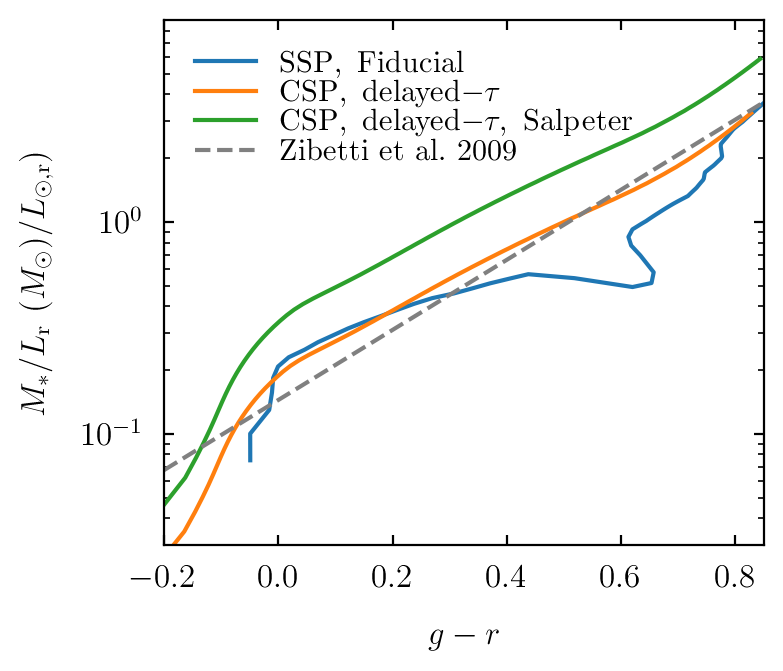

In [20]:
plt.figure(figsize = (4.0, 3.5))
plt.xlabel(r'$g-r$')
plt.ylabel(r'$M_{\ast} / L_{\rm r} \ (M_\odot) / L_{\rm \odot, r})$')
plt.yscale('log')
plt.xlim(-0.2, 0.85)
plt.ylim(3E-2, 9E0)

models_use = [ssp, csp_del_tau2, csp_del_tau2_salp]
labels_use = [r'$\mathrm{SSP,\ Fiducial}$', r'$\mathrm{CSP,\ delayed-}\tau$', 
              r'$\mathrm{CSP,\ delayed-}\tau,\ \mathrm{Salpeter}$']

for i, m in enumerate(models_use):
    Mg = m.get_absolute_mags(zf, filters = 'sloan_g', zs = zs)
    Mr = m.get_absolute_mags(zf, filters = 'sloan_r', zs = zs)
    gr = Mg - Mr
    ml_r = m.get_rest_ml_ratios(zf, filters = 'sloan_r', zs = zs)
    plt.plot(gr, ml_r, label = labels_use[i])

gr_plot = np.linspace(-0.2, 1.0, 10)
ml_zibetti = mlZibetti(gr_plot)
plt.plot(gr_plot, ml_zibetti, '--', color = 'gray', label = r'$\mathrm{Zibetti\ et\ al.\ 2009}$')

plt.legend(loc = 2, labelspacing = 0.08)
plt.show()

Indeed, we find a near-linear relation between color and $\log_{10} M_\ast / L$, although the normalization clearly depends on the IMF (and metallicity, which is not shown). The plot also shows the fitting function of [Zibetti et al. 2009](http://adsabs.harvard.edu/abs/2009MNRAS.400.1181Z) as a dashed line, which describes our CSP quite well. Clearly, knowing the color of a galaxy helps enormously in determining the mass-to-light ratio we should use to infer its mass.

We can use the fitting function to infer the stellar mass of the Milky Way. We use the values from Table 7 of [Licquia & Newman 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...831...71L/abstract).

In [21]:
from routines import obs_utils

gr_MW = obs_utils.gr_MW
Mr_MW = obs_utils.Mr_MW
Mr_sun = obs_utils.solar_mag['r']

ml_zibetti = mlZibetti(gr_MW)
Lr_MW = 10**(0.4 * (Mr_sun - Mr_MW))
Mstar_MW = ml_zibetti * Lr_MW

print('Abs. mag. in r-band  = %.2f' % (Mr_MW))
print('Luminosity in r-band = %.1e Lsun' % (Lr_MW))
print('Mass-to-light ratio  = %.2f Msun / Lsun' % (ml_zibetti))
print('Stellar mass (M/L)   = %.1e Msun' % (Mstar_MW))
print('Stellar mass (lit.)  = %.1e Msun' % (obs_utils.Mstar_MW))

Abs. mag. in r-band  = -21.82
Luminosity in r-band = 4.0e+10 Lsun
Mass-to-light ratio  = 1.91 Msun / Lsun
Stellar mass (M/L)   = 7.6e+10 Msun
Stellar mass (lit.)  = 5.7e+10 Msun


Let's now compare our estimates to the SDSS pipeline.

In [22]:
from routines import obs_sdss

data = obs_sdss.loadSdssSpecSampleExtra()

print('Found %d galaxies with the following fields:' % (len(data)))
for k in data.dtype.names:
    print(k)

Found 672813 galaxies with the following fields:
ra
dec
mjd
plate
fiberID
class
z
zErr
rChi2
velDisp
velDispErr
extinction_u
extinction_g
extinction_r
extinction_i
extinction_z
fiberMag_u
fiberMag_g
fiberMag_r
fiberMag_i
fiberMag_z
modelMag_u
modelMag_g
modelMag_r
modelMag_i
modelMag_z
cmodelMag_u
cmodelMag_g
cmodelMag_r
cmodelMag_i
cmodelMag_z
phioffset_r
fracdeV_r
deVRad_r
deVRadErr_r
deVAB_r
deVABErr_r
deVPhi_r
lnLDeV_r
deVMag_r
deVMagErr_r
expRad_r
expRadErr_r
expAB_r
expABErr_r
expPhi_r
lnLExp_r
expMag_r
expMagErr_r
petroMag_u
petroMag_g
petroMag_r
petroMag_i
petroMag_z
petroRad_u
petroRad_g
petroRad_r
petroRad_i
petroRad_z
petroR50_r
petroR90_r
petroR50Err_r
petroR90Err_r
h_alpha_flux
h_alpha_flux_err
oiii_5007_flux
oiii_5007_flux_err
d4000
d4000_err
bptclass
lgm_tot_p50
sfr_tot_p50
objID
specObjID
K_u
K_g
K_r
K_i
K_z
color_ug
color_gr
color_ri
color_iz
DM
dL
dA
M_model_u
m_model_u
M_cmodel_u
m_cmodel_u
M_petro_u
m_petro_u
M_fiber_u
m_fiber_u
M_model_g
m_model_g
M_cmodel_g
m_cmod

The SDSS data contains estimates of the stellar mass and SFR from the MPA-JHU catalog (see [SDSS Docs](https://skyserver.sdss.org/dr8/en/help/browser/description.asp?n=galSpecExtra&t=U)). We are using the medians of the probability distributions. Let's compare the estimate for stellar mass to our own based on the M/L ratio as computed above.

1.3269760367232184


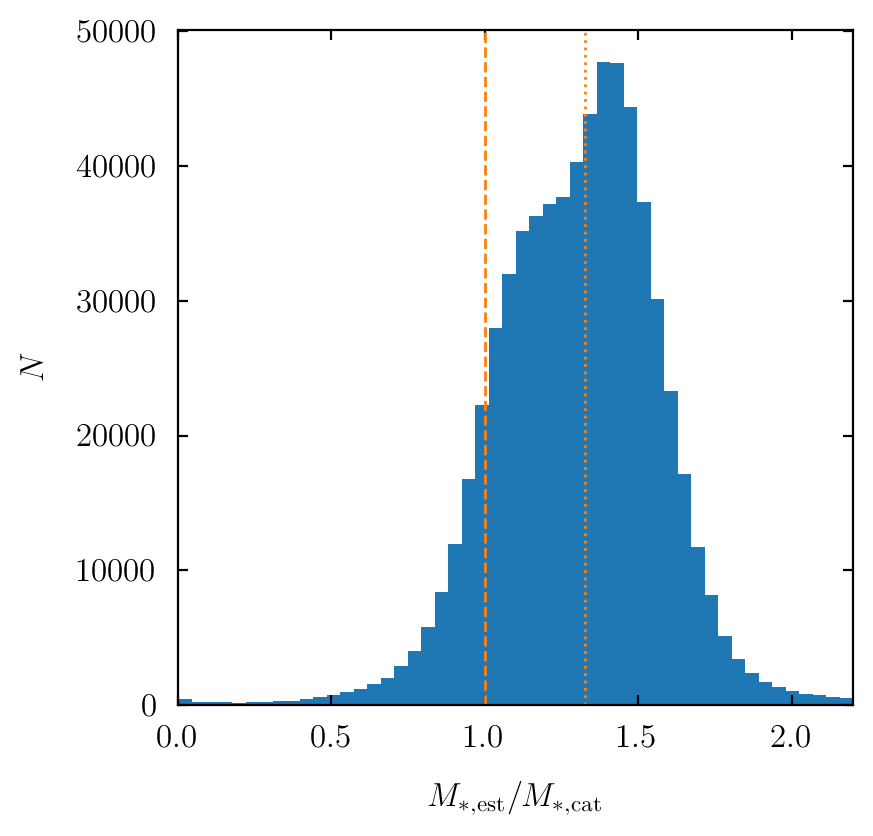

In [23]:
Mstar_cat = 10**data['lgm_tot_p50']
Mr = data['M_model_r']
gr = data['color_gr']
ml_ratio = mlZibetti(gr)
Lr = 10**(0.4 * (Mr_sun - Mr))
Mstar_est = ml_ratio * Lr

mask = (Mstar_est > 0.0) & (Mstar_cat > 0.0)
ratio = Mstar_est[mask] / Mstar_cat[mask]
print(np.median(ratio))

plt.figure()
plt.xlim(0.0, 2.2)
plt.xlabel(r'$M_{\rm \ast, est} / M_{\rm \ast, cat}$')
plt.ylabel(r'$N$')
plt.hist(ratio, range = [0.0, 2.2], bins = 50)
plt.axvline(1.0, ls = '--', lw = 1.0, color = cmn.color_cycle[1])
plt.axvline(np.median(ratio), ls = ':', lw = 1.0, color = cmn.color_cycle[1])
plt.show()

Not bad, although the median of our masses is higher by a factor of $\sim 1.3$. 

#### 7.4.2) SFR indicators

Let's do the same for SFR, where we estimate SFR based on the Halpha flux given in the SDSS data.

0.14670354607550656


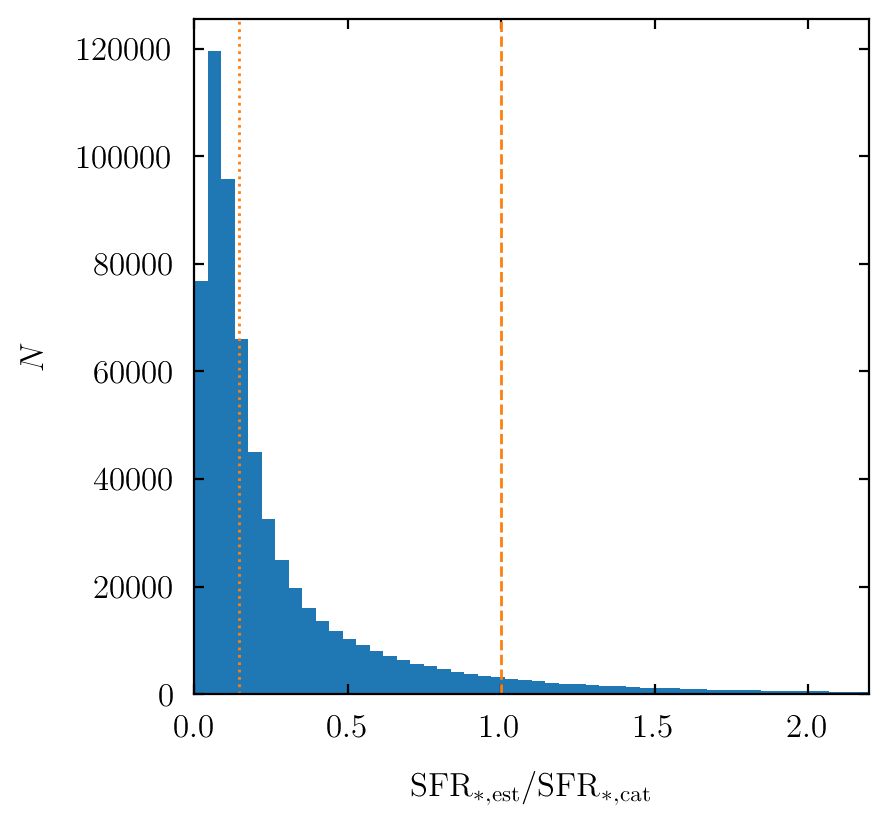

In [24]:
from colossus.utils import constants

sfr_cat = 10**data['sfr_tot_p50']

# Halpha flux in erg/s/cm^2, multiply by distance-sphere are in cm^2 to get erg/s
dL_cm = data['dL'] * constants.MPC
h_alpha = 1E-17 * data['h_alpha_flux'] * 4.0 * np.pi * dL_cm**2
sfr_est = h_alpha / 10**41.27

mask = (sfr_est > 0.0) & (sfr_cat > 0.0)
ratio = sfr_est[mask] / sfr_cat[mask]
print(np.median(ratio))

plt.figure()
plt.xlim(0.0, 2.2)
plt.xlabel(r'${\rm SFR}_{\rm \ast, est} / {\rm SFR}_{\rm \ast, cat}$')
plt.ylabel(r'$N$')
plt.hist(ratio, range = [0.0, 2.2], bins = 50)
plt.axvline(1.0, ls = '--', lw = 1.0, color = cmn.color_cycle[1])
plt.axvline(np.median(ratio), ls = ':', lw = 1.0, color = cmn.color_cycle[1])
plt.show()

The $H\alpha$ estimator clearly underestimates the more sophisticated SFR measurement based on multiple indicators from the SDSS database (see e.g. [Salim et al. 2007](https://ui.adsabs.harvard.edu/abs/2007ApJS..173..267S/abstract)). The main reason is that the $H\alpha$ line can be dust-obscured. Clearly, by itself this line is not a good SFR estimator for the general galaxy population.

### 7.5) Observed correlations

In the following plots, we use the SDSS catalog values for $M_\ast$ and SFR to avoid the difficulties discussed above.

#### 7.5.1) The star formation main sequence

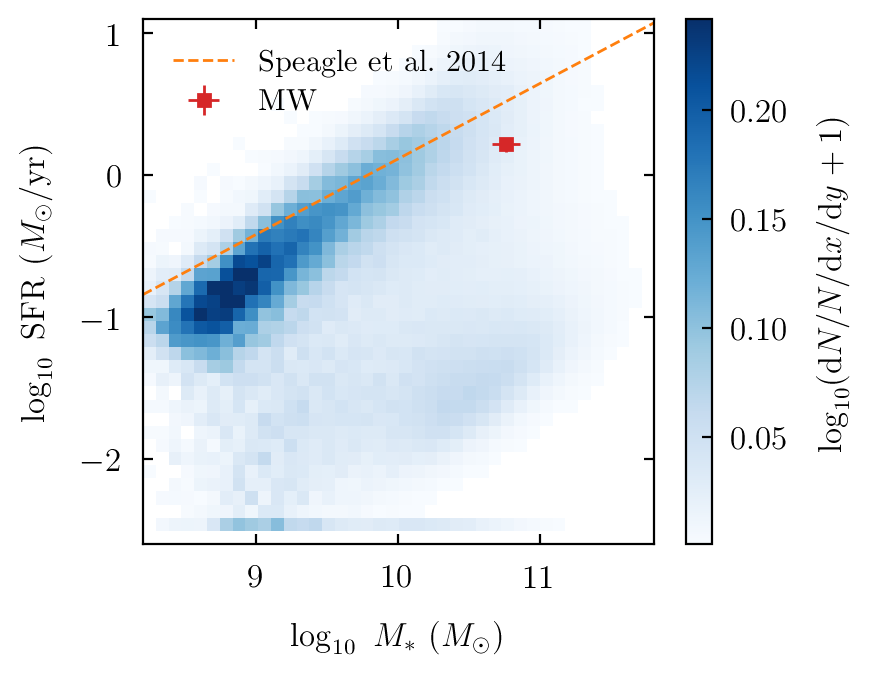

In [25]:
sfr_min = 10**-2.5

mask_all = (Mstar_cat > 0.0) & (sfr_cat >= 0.0) & (data['z'] > 0.02)
mstar = Mstar_cat[mask_all]
sfr = sfr_cat[mask_all]
data_masked = data[mask_all]

sfr[sfr < sfr_min] = sfr_min
x = np.log10(mstar)
y = np.log10(sfr)

x_lo = 8.2
x_hi = 11.8
y_lo = -2.6
y_hi = 1.1

cmap = plt.get_cmap('Blues')
cmap.set_under('#FFFFFF')

hist, _, _ = np.histogram2d(x, y, bins = (40, 40), range = [[x_lo, x_hi], [y_lo, y_hi]], 
                            weights = data_masked['1/Vmax'], density = True)
hist = np.log10(hist.T[::-1] + 1.0)
vmax = np.max(hist) * 0.9

plt.figure(figsize = (4.5, 3.5))
plt.subplots_adjust(right = 0.91)
plt.xlabel(r'$\log_{10}\ M_\ast\ (M_\odot)$')
plt.ylabel(r'$\log_{10}\ {\rm SFR}\ (M_\odot / {\rm yr})$')
plt.imshow(hist, extent = [x_lo, x_hi, y_lo, y_hi], interpolation = 'nearest', aspect = 'auto',
           cmap = cmap, vmin = 1E-3, vmax = vmax)
plt.xlim(x_lo, x_hi)
plt.ylim(y_lo, y_hi)

# Speagle relation
t0 = cmn.cosmo.age(0.15)
x_plot = np.array([x_lo, x_hi])
y_plot = (0.84 - 0.026 * t0) * x_plot - (6.51 - 0.11 * t0)
plt.plot(x_plot, y_plot, ls = '--', color = cmn.color_cycle[1], lw = 1.0, 
         label = r'$\mathrm{Speagle\ et\ al.\ 2014}$')

# MW
log_mstar_mw = np.log10(obs_utils.Mstar_MW)
log_mstar_mw_lo = np.log10(obs_utils.Mstar_MW_lo)
log_mstar_mw_hi = np.log10(obs_utils.Mstar_MW_hi)
xerr_mw = [[log_mstar_mw - log_mstar_mw_lo], [log_mstar_mw_hi - log_mstar_mw]]
log_sfr_mw = np.log10(obs_utils.SFR_MW)
log_sfr_mw_lo = np.log10(obs_utils.SFR_MW_lo)
log_sfr_mw_hi = np.log10(obs_utils.SFR_MW_hi)
yerr_mw = [[log_sfr_mw - log_sfr_mw_lo], [log_sfr_mw_hi - log_sfr_mw]]
plt.errorbar([log_mstar_mw], [log_sfr_mw], xerr = xerr_mw, yerr = yerr_mw, fmt = 's', ms = 4.0, color = cmn.color_cycle[3], 
             ecolor = cmn.color_cycle[3], lw = 1.0, label = r'$\mathrm{MW}$')

cbar = plt.colorbar()
cbar.set_label(r'$\log_{10} ({\rm d} N / N / {\rm d} x / {\rm d} y + 1)$')
plt.legend(loc = 2)
plt.show()

The SFR of star-forming galaxies correlates strongly with their stellar mass: bigger galaxies make more stars, on average. The approximately linear relationship (in log space) is called the "star formation main sequence." Below the main sequence, the "green valley" contains galaxies that are "quenching," meaning that their SFR is decreasing and they are moving to the "red and dead" cloud at the bottom.

It makes sense the overall bigger galaxies have both more stars and more gas, which allows them to form more stars. But do they get more or less efficient with mass? We can answer this question by plotting the "specific SFR," which is the ratio of SFR per stellar mass.

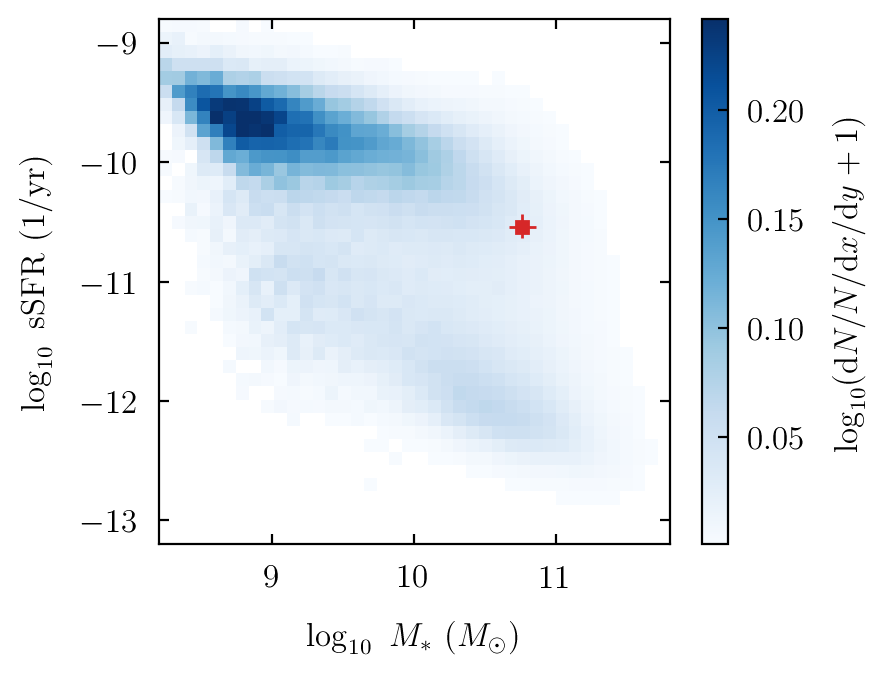

In [26]:
sfr = sfr_cat[mask_all]
sfr[sfr < 1E-10] = 1E-10
y = np.log10(sfr / mstar)

y_lo = -13.2
y_hi = -8.8

hist, _, _ = np.histogram2d(x, y, bins = (40, 40), range = [[x_lo, x_hi], [y_lo, y_hi]], 
                            weights = data_masked['1/Vmax'], density = True)
hist = np.log10(hist.T[::-1] + 1.0)

plt.figure(figsize = (4.5, 3.5))
plt.subplots_adjust(right = 0.91)
plt.xlabel(r'$\log_{10}\ M_\ast\ (M_\odot)$')
plt.ylabel(r'$\log_{10}\ {\rm sSFR}\ (1 / {\rm yr})$')
plt.imshow(hist, extent = [x_lo, x_hi, y_lo, y_hi], interpolation = 'nearest', aspect = 'auto',
           cmap = cmap, vmin = 1E-3, vmax = vmax)
plt.xlim(x_lo, x_hi)
plt.ylim(y_lo, y_hi)

# MW; we are lazy about the exact error bars for sSFR since the error bars on mass dominate
plt.errorbar([log_mstar_mw], [log_sfr_mw - log_mstar_mw], xerr = xerr_mw, yerr = xerr_mw, fmt = 's', ms = 4.0, 
             color = cmn.color_cycle[3], ecolor = cmn.color_cycle[3], lw = 1.0, label = r'$\mathrm{MW}$')

cbar = plt.colorbar()
cbar.set_label(r'$\log_{10} ({\rm d} N / N / {\rm d} x / {\rm d} y + 1)$')
plt.show()

We see that galaxies become less efficient per mass at higher masses, which is not surprising given the shape of the stellar mass-halo mass relation and our insights about gas cooling.

#### 7.5.2) The relationship between sSFR and color

The main sequence plot above resembles the magnitude-color diagram, which reminds us to test whether the age-color relationship from our SPS experiments still comes through in integrated galaxy sSFRs and colors. We use the sSFR rather than SFR because the latter increases in absolute terms with stellar mass, whereas color measures relative fluxes.

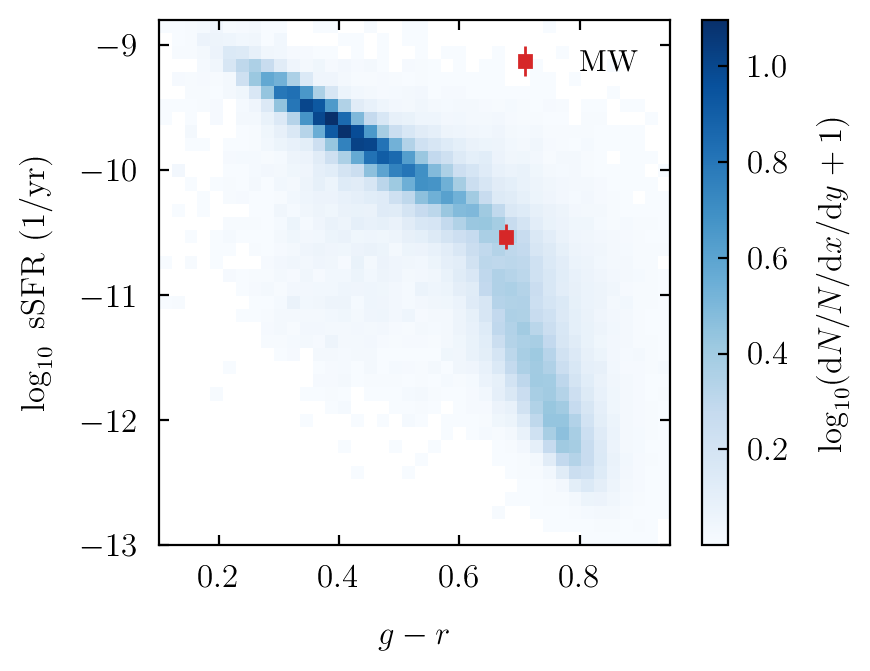

In [27]:
sfr = sfr_cat[mask_all]
sfr[sfr < sfr_min] = sfr_min
x = data_masked['color_gr']

x_lo = 0.1
x_hi = 0.95
y_lo = -13.0
y_hi = -8.8

hist, _, _ = np.histogram2d(x, y, bins = (40, 40), range = [[x_lo, x_hi], [y_lo, y_hi]], 
                            weights = data_masked['1/Vmax'], density = True)
hist = np.log10(hist.T[::-1] + 1.0)

plt.figure(figsize = (4.5, 3.5))
plt.subplots_adjust(right = 0.91)
plt.xlabel(r'$g-r$')
plt.ylabel(r'$\log_{10}\ {\rm sSFR}\ (1 / {\rm yr})$')
plt.imshow(hist, extent = [x_lo, x_hi, y_lo, y_hi], interpolation = 'nearest', aspect = 'auto',
           cmap = cmap, vmin = 1E-3, vmax = np.max(hist))
plt.xlim(x_lo, x_hi)
plt.ylim(y_lo, y_hi)

# MW
plt.errorbar([gr_MW], [log_sfr_mw - log_mstar_mw], yerr = xerr_mw, fmt = 's', ms = 4.0, 
             color = cmn.color_cycle[3], ecolor = cmn.color_cycle[3], lw = 1.0, label = r'$\mathrm{MW}$')

cbar = plt.colorbar()
cbar.set_label(r'$\log_{10} ({\rm d} N / N / {\rm d} x / {\rm d} y + 1)$')
plt.legend(loc = 1)
plt.show()

The relationship is tight and follows the color evolution of stellar populations (fast color evolution when a high sSFR means young stars dominate), and slow color evolution at low sSFR when old stars dominate. We can also visualize the bimodality in sSFR.

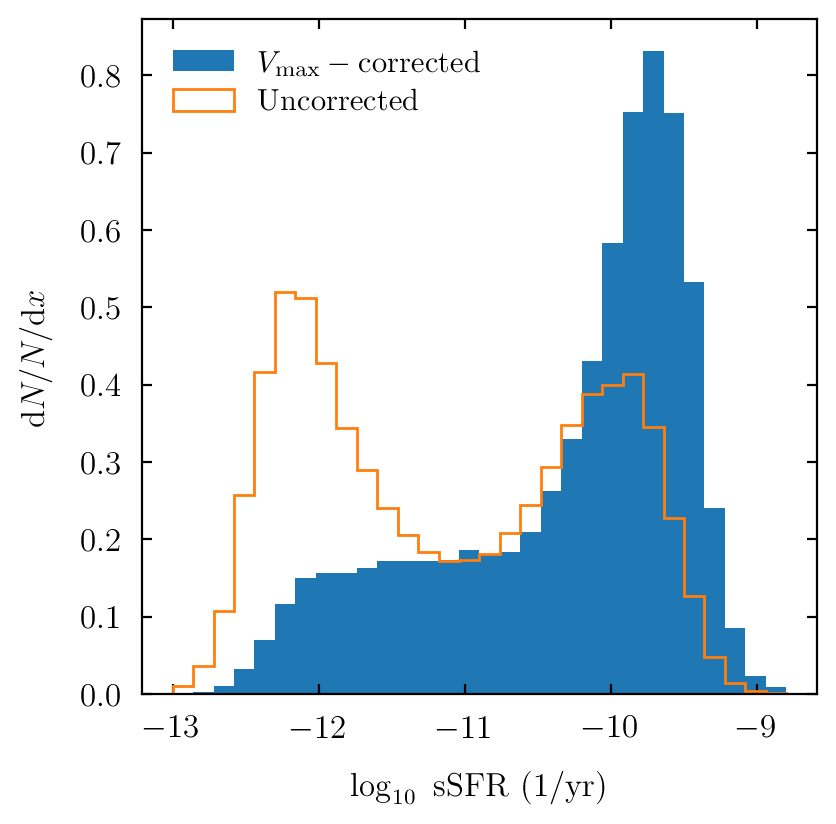

In [28]:
plt.figure()
plt.xlabel(r'$\log_{10}\ {\rm sSFR}\ (1 / {\rm yr})$')
plt.ylabel(r'${\rm d}N / N / {\rm d}x$')

plt.hist(y, range = [y_lo, y_hi], bins = 30, weights = data_masked['1/Vmax'], density = True, 
         label = r'$V_{\rm max}-\mathrm{corrected}$')
plt.hist(y, range = [y_lo, y_hi], bins = 30, density = True, histtype = 'step',
        label = r'$\mathrm{Uncorrected}$')

plt.legend()
plt.show()

When applying the $V_{\rm max}$ correction, the bimodality becomes less visible. Without the correction it is much clearer, since many low-sSFR, red ellipticals are luminous and thus preferrably in our sample.